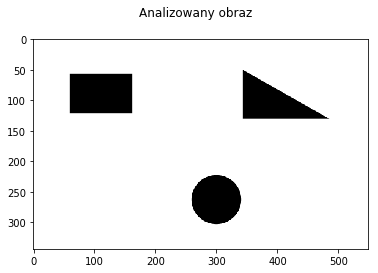

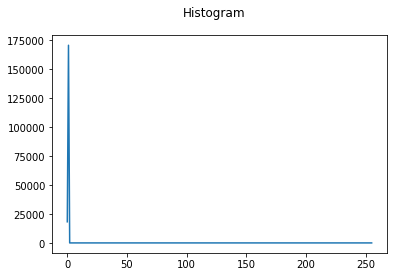

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray


path = './'

image = io.imread(path + 'pattern1.png')

image = rgb2gray(image)

plt.imshow(image, cmap='gray')
plt.axis('on')
plt.suptitle('Analizowany obraz')
plt.show()

bins=np.arange(0, 257)
histo = np.histogram(image, bins=bins)

hist, bins = histo

plt.plot(bins[:-1], hist)
plt.suptitle('Histogram')
plt.show()

Prog binaryzacji:  0.5809978768382353


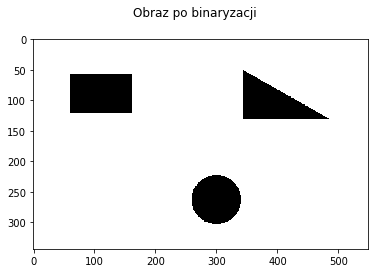

In [4]:
from skimage import filters

th = filters.threshold_otsu(image)
print('Prog binaryzacji: ', th)

binary = image < th

plt.imshow(binary, cmap='binary')
plt.axis('on')
plt.suptitle('Obraz po binaryzacji')
plt.show()

In [5]:
from scipy import ndimage as ndi
label_objects, nb_labels = ndi.label(binary)

sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0

figures = mask_sizes[label_objects]

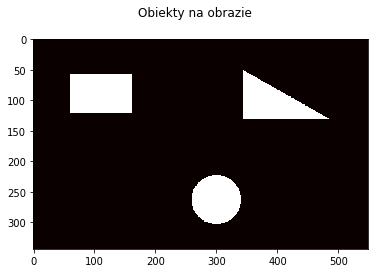

(344, 549)
(344, 549)
3


In [6]:
plt.imshow(figures, cmap="hot")
plt.axis('on')
plt.suptitle('Obiekty na obrazie')
plt.show()

print(figures.shape)
print(label_objects.shape)
print(nb_labels)

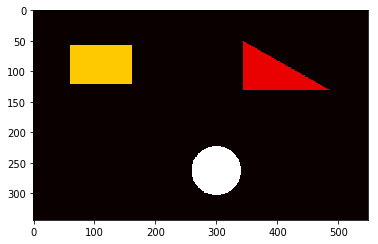

[171322   5711   6695   5128] [False  True  True  True]
0
1
2
6695


In [8]:
plt.imshow(label_objects,cmap='hot')
plt.show()

mask_sizes
print(sizes, mask_sizes)
print(label_objects[100][300])
print(label_objects[100][400])
print(label_objects[100][100])
# print label_objects.size, label_objects.shape
print(np.sum(label_objects == 2))

In [9]:
no_of_object = 2

def cog(labelledImage, objNumber):
    cx = 0
    cy = 0
    for y in range(labelledImage.shape[0]):
        for x in range(labelledImage.shape[1]):
            if labelledImage[y,x] == objNumber:
                cy = cy + y
                cx = cx + x

    cx = cx / sizes[objNumber]
    cy = cy / sizes[objNumber]

    return int(cy), int(cx)

cogs = []
for i in range(nb_labels):
    cogs.append(cog(label_objects, i+1))

print(cogs)

[(103, 390), (89, 111), (262, 300)]


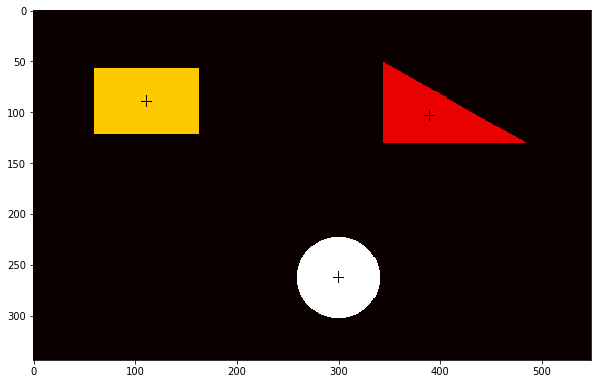

In [10]:
def drawMarkers(image, coords):

    image = np.copy(image)
    
    for item in coords:
        y,x = item
        for j in range(y-5, y+6):
            image[j,x] = 0
        for i in range(x-5, x+6):
            image[y,i] = 0
            
    return image


lo = drawMarkers(label_objects, cogs)
plt.figure(figsize=(10,10))
plt.imshow(lo,cmap='hot')
plt.show()

In [11]:
from operator import itemgetter

cogs2 = sorted(cogs, key=itemgetter(0,1))
print(cogs2)

from numpy.linalg import norm
cogs3 = sorted(cogs, key=lambda tup: norm(tup))
print(cogs3)

for item in cogs3:
    print(norm(item))

[(89, 111), (103, 390), (262, 300)]
[(89, 111), (262, 300), (103, 390)]
142.27438279606065
398.3013934196063
403.37203671052856


In [12]:
import math

p1 = 0
p2 = 1

print(cogs3[p1], cogs3[p2])
print(label_objects.shape[0])

(89, 111) (262, 300)
344


In [13]:
y = cogs3[p1][0] - cogs3[p2][0]
x = cogs3[p1][1] - cogs3[p2][1]
print(x,y)

angle = math.degrees(math.atan2(-y, x)) + 180

print(int(angle))

-189 -173
317


In [14]:
def getFigure(labelledImage, objNumber):
    
    points = []
    for y in range(labelledImage.shape[0]):
        for x in range(labelledImage.shape[1]):
            if labelledImage[y,x] == objNumber:
                points.append((y,x))

    return points

print(nb_labels)

3


In [15]:
for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)
    print(len(pts))

5711
6695
5128


In [16]:

def cog2(points):
    mx=0
    my=0
    for (y,x) in points:
        mx = mx + x
        my = my + y
    mx = mx/len(points)
    my = my/len(points)
    
    return [my, mx]


for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)
    
    print('Liczba punktow: ',len(pts),' Srodek ciezkosci: ', cog2(pts))

Liczba punktow:  5711  Srodek ciezkosci:  [103.69077219401156, 390.8410085799335]
Liczba punktow:  6695  Srodek ciezkosci:  [89.0, 111.0]
Liczba punktow:  5128  Srodek ciezkosci:  [262.5, 300.0]


In [17]:
from scipy.spatial import distance

def computeBB(points):
    
    s = len(points)
    my,mx = cog2(pts)
    
    r = 0
    for point in points:
         r = r + distance.euclidean(point,(my,mx))**2
            
    return s/(math.sqrt(2*math.pi*r))

In [18]:
for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)
    bb = computeBB(pts)
    
    print('Liczba punktow: ',len(pts), ' Srodek ciezkosci: ', cog2(pts), ' Blair-Bliss: ', bb)

Liczba punktow:  5711  Srodek ciezkosci:  [103.69077219401156, 390.8410085799335]  Blair-Bliss:  0.783842086724145
Liczba punktow:  6695  Srodek ciezkosci:  [89.0, 111.0]  Blair-Bliss:  0.9284876278556973
Liczba punktow:  5128  Srodek ciezkosci:  [262.5, 300.0]  Blair-Bliss:  0.999985365301193


In [19]:
def computeFeret(points):
    
    px = [x for (y,x) in points]
    py = [y for (y,x) in points]
    
    fx = max(px) - min(px)
    fy = max(py) - min(py)
    
    return float(fy)/float(fx)    

In [20]:
for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)
    bb = computeBB(pts)
    feret = computeFeret(pts)
    
    print('Liczba punktow: ',len(pts),'\nSrodek ciezkosci: ', cog2(pts),'\nBlair-Bliss: ', bb,'\nFeret: ',feret, '\n---\n')

Liczba punktow:  5711 
Srodek ciezkosci:  [103.69077219401156, 390.8410085799335] 
Blair-Bliss:  0.783842086724145 
Feret:  0.5642857142857143 
---

Liczba punktow:  6695 
Srodek ciezkosci:  [89.0, 111.0] 
Blair-Bliss:  0.9284876278556973 
Feret:  0.6274509803921569 
---

Liczba punktow:  5128 
Srodek ciezkosci:  [262.5, 300.0] 
Blair-Bliss:  0.999985365301193 
Feret:  0.9875 
---



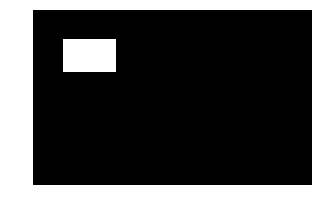

{'m00': 6695.0, 'm10': 743145.0, 'm01': 595855.0, 'm20': 88407475.0, 'm11': 66139905.0, 'm02': 55387735.0, 'm30': 11127110085.0, 'm21': 7868265275.0, 'm12': 6148038585.0, 'm03': 5348990335.0, 'mu20': 5918379.999999985, 'mu11': 0.0, 'mu02': 2356640.0, 'mu30': 1.9073486328125e-06, 'mu21': -5.960464477539062e-07, 'mu12': -2.9802322387695312e-08, 'mu03': 0.0, 'nu20': 0.132038834951456, 'nu11': 0.0, 'nu02': 0.052576549663928315, 'nu30': 5.200602123957273e-16, 'nu21': -1.6251881637366476e-16, 'nu12': -8.125940818683238e-18, 'nu03': 0.0}
[[1.84615385e-01]
 [6.31425478e-03]
 [5.34124065e-31]
 [2.88489064e-31]
 [1.11166163e-61]
 [1.87264264e-32]
 [2.15935659e-62]]


In [21]:
i = 1
pts = getFigure(label_objects, i+1)
obj = np.zeros(image.shape, dtype='uint8')

for coords in pts:
    obj[coords] = 1

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5))
plt.imshow(obj, cmap="gray")
plt.axis('off')
plt.show()

import cv2

moments = cv2.moments(obj)
print(moments)
hu = cv2.HuMoments(moments)
print(hu)